In [1]:
import os
from rdflib import Graph 
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()
import numpy as np

In [2]:
client = OpenAI()

In [3]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=Nc44e01bb13fe4a0fa23afa7af625f8cd (<class 'rdflib.graph.Graph'>)>

In [4]:
# Bacnet Devices

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Device
query_for_devices = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name
WHERE {
  ?device a bacnet:bacnet_Device ;
          bacnet:device_name ?device_name .
}
"""

# Run the query for devices
for row in g.query(query_for_devices):
    device_name = row[0]

    # Create the document
    content = device_name.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [5]:
# Bacnet Points

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Point
query_for_points = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name ?point_name ?present_value ?unit
WHERE {
  ?point a bacnet:bacnet_Point ;
         bacnet:device_name ?device_name ;
         bacnet:object_name ?point_name ;
         bacnet:present_value ?present_value ;
         bacnet:object_units ?unit .
}
"""

# Run the query for points
for row in g.query(query_for_points):
    device_name, point_name, present_value, unit = row
    
    content = point_name.value 
    documents.append(Document(page_content=content, metadata={"type": "bacnet_point"}))

In [6]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [7]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

In [8]:
matrix = np.vstack(embs)
matrix.shape

(17122, 1536)

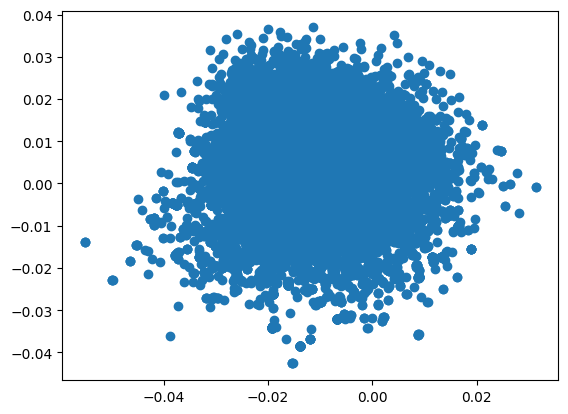

In [9]:
# Plot the data
import matplotlib.pyplot as plt

plt.scatter(matrix[:,0], matrix[:,1])
plt.show()

In [10]:
# Computer required parameters of DBSCAN clustering
# Use KNN to find the optimal epsilon
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find the optimal epsilon
nbrs = NearestNeighbors(n_neighbors=5).fit(matrix)

distances, indices = nbrs.kneighbors(matrix)

distances = np.sort(distances, axis=0)

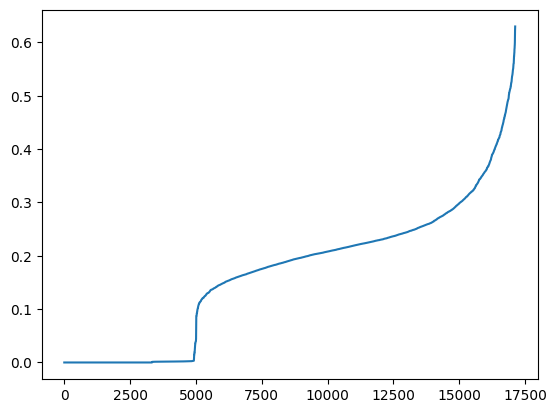

In [11]:
# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
import matplotlib.pyplot as plt

plt.plot(distances[:, 4])
plt.show()

In [12]:
# Use knee locator to find the optimal epsilon
from kneed import KneeLocator

kneedle = KneeLocator(
    range(1, distances.shape[0] + 1), distances[:, 1], curve="convex", direction="increasing"
)

kneedle.knee_y

0.4089550764604022

In [13]:
# Compute the DBSCAN clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=kneedle.knee_y, min_samples=3).fit(matrix)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the results
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 241
Estimated number of noise points: 354


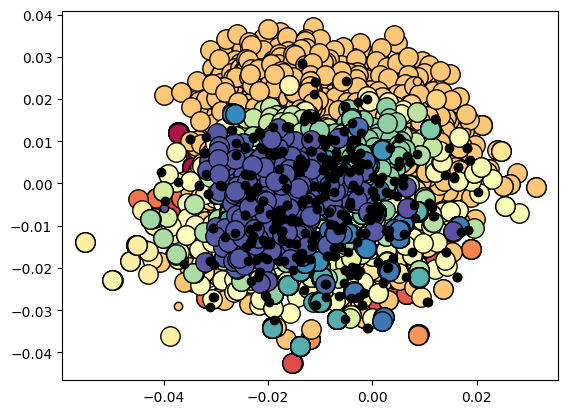

In [14]:
# Plot the results
import matplotlib.pyplot as plt

unique_labels = set(labels)
embs = np.array(embs)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embs[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embs[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6) 

In [15]:
# Create a dict of clusters and their bacnet devices
clusters = {}
for i in range(min(len(labels), len(documents))):
    if labels[i] in clusters:
        clusters[labels[i]].append(documents[i].page_content)
    else
        clusters[labels[i]] = [documents[i].page_content]

# Pretty print the clusters dict
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters)

{   -1: [   'P3-DISCHARGE-TEMP',
            'P3-DISCHARGE-TEMP',
            'PRIMARY-CW-SUCK-TEMP',
            'PRIMARY-CW-SUCK-TEMP',
            'ChilledWaterDeltaT',
            'ChilledWaterDeltaT',
            'CW-SAFE-SP',
            'GEO-PUMP-MAX-SPEED',
            'GEO-PUMP-MIN-SPEED',
            'GEO-TOTAL-BTU',
            'GEO-TOTAL-BTU',
            'OA-ENTHALPY-SP',
            'POOL-TEMP-SP1',
            'POOL-TEMP-SP2',
            'PRI-CW-FLOW-SP',
            'PRI-LOOP-TOTAL-FLOW',
            'CHP-ROTATION-PRG',
            'CHP-ROTATION-PRG',
            'DELTA/P10&P11-FAIL-PRG',
            'MAU-1-INTEGRATION',
            'SECONDARY-LOAD-PRG',
            'CHILLED WATER SCHEDULE',
            'CONDENSER PLANT SCHEDULE',
            'POOL PAK SCHEDULE',
            'ActiveCapacityLimit',
            'ActiveLvgWaterTarget',
            'AIFaultAlarm',
            'ChillerCapacity',
            'CompHours',
            'CompMotorCurrentPercent',
            'Co